In [1]:
!pip install seaborn
!pip install nltk

import nltk
import seaborn as sns
import pandas as pd
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import numpy as np
import heapq
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
import pickle
from keras.optimizers import RMSprop

nltk.download('stopwords')

2023-05-20 14:51:33.907680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/belinda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Read the Excel file into a pandas DataFrame
df = pd.read_excel('./writing_aid_dataset.xlsx')

# Print the head of the DataFrame
print(df.head())

                                            English
0         december is the twelfth month of the year
1             mr. ddumba is our teacher for English
2                               where are you going
3  when i was going to kampala i saw kalerwe market
4                          kasanje is my sub-county


In [3]:
# Tokenize English sentences
regexp = RegexpTokenizer('\w+')

df['eng_token']=df['English'].apply(regexp.tokenize)
print(df.head())

                                            English   
0         december is the twelfth month of the year  \
1             mr. ddumba is our teacher for English   
2                               where are you going   
3  when i was going to kampala i saw kalerwe market   
4                          kasanje is my sub-county   

                                           eng_token  
0  [december, is, the, twelfth, month, of, the, y...  
1       [mr, ddumba, is, our, teacher, for, English]  
2                           [where, are, you, going]  
3  [when, i, was, going, to, kampala, i, saw, kal...  
4                     [kasanje, is, my, sub, county]  


In [4]:
# remove stop words
stopwords = nltk.corpus.stopwords.words("english")

df['eng_token'] = df['eng_token'].apply(lambda x: [item.lower() for item in x if item not in stopwords])
df['eng_string'] = df['eng_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
print(df.head(3))

                                     English   
0  december is the twelfth month of the year  \
1      mr. ddumba is our teacher for English   
2                        where are you going   

                          eng_token                   eng_string  
0  [december, twelfth, month, year]  december twelfth month year  
1    [mr, ddumba, teacher, english]       ddumba teacher english  
2                           [going]                        going  


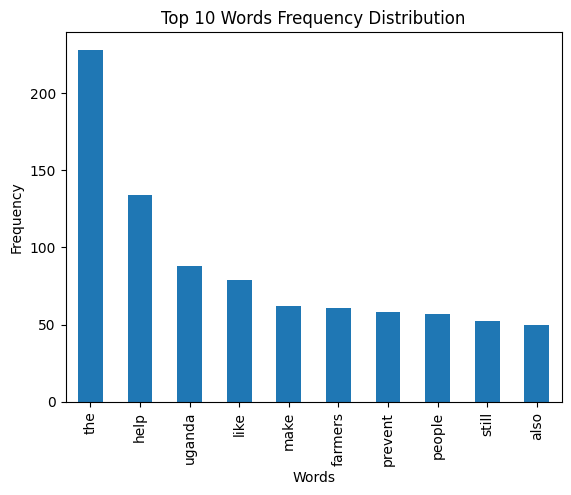

In [5]:
# Access the tokenized words column and parse tokens into a list
eng_words_list = [word for sentence in df['eng_string'] for word in sentence.split()]

# Create frequency distribution of the tokens
freq_dist = pd.Series(eng_words_list).value_counts()

# Plot the top 10 words
top_10_words = freq_dist.head(10)
top_10_words.plot(kind='bar')

# Set plot labels and title
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Frequency Distribution')

# Display the plot
plt.show()

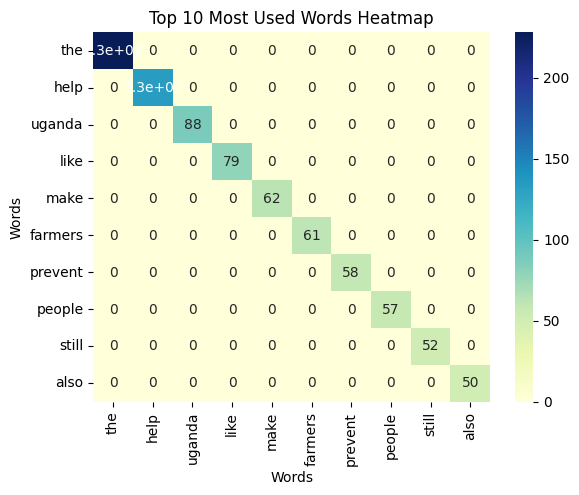

In [6]:
# Calculate word frequencies
word_counts = pd.Series(eng_words_list).value_counts()

# Select the top 10 most used words
top_10_words = word_counts.head(10)

# Create a matrix-like representation with the top 10 words
word_matrix = pd.DataFrame(index=top_10_words.index, columns=top_10_words.index)

# Fill the matrix with word frequencies
for word1 in word_matrix.index:
    for word2 in word_matrix.columns:
        if word1 == word2:
            word_matrix.loc[word1, word2] = top_10_words[word1]
        else:
            word_matrix.loc[word1, word2] = 0

# Convert the matrix values to numeric
word_matrix = word_matrix.astype(int)

# Create the heatmap using seaborn
sns.heatmap(word_matrix, annot=True, cmap='YlGnBu')

# Set plot labels and title
plt.xlabel('Words')
plt.ylabel('Words')
plt.title('Top 10 Most Used Words Heatmap')

# Display the plot
plt.show()